In [1]:
!which python

/Users/pushkalm11/miniconda3/envs/unrolling/bin/python


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

In [3]:
import random
import scipy
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat

In [4]:
import networkx as nx
import sys

In [5]:
import tensorflow as tf
from tensorflow.math import scalar_mul as c_mul
from keras.callbacks import EarlyStopping

In [6]:
print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [7]:
X_train = loadmat('./Dataset/X_train.mat')['X_Ground']
Adj_train = loadmat('./Dataset/Adj.mat')['A_Ground']

N, T = X_train.shape

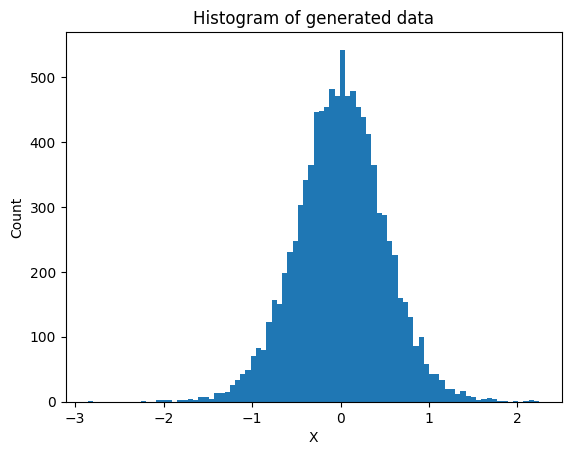

In [8]:
plt.hist(np.array(X_train).flatten(), bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

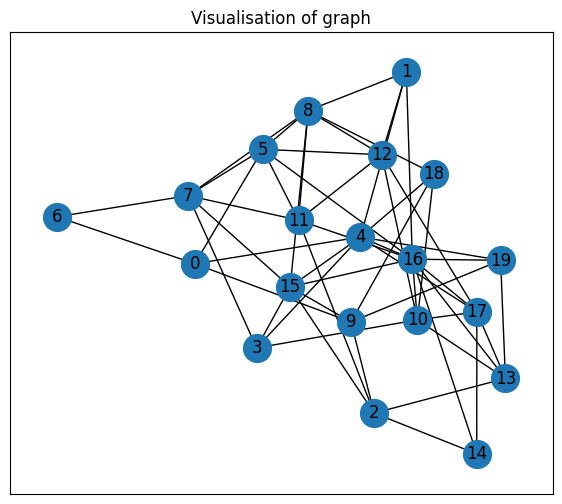

In [9]:
fig = plt.figure(figsize = (7, 6))
rows, cols = np.where(Adj_train == 1)
edges = zip(rows.tolist(), cols.tolist())

gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw_networkx(gr, node_size = 400)

plt.title("Visualisation of graph")
plt.show()

In [10]:
print(N, T)

20 500


In [11]:
dt = np.zeros([T - 1, T])

for i in range(T - 1):
    dt[i, i] = -1
    dt[i, i - 1] = 1

d = dt.T
d = np.concatenate((d, np.zeros([T, 1])), axis = 1) 
d[T - 1, T - 1] = -1
d = d.T
d[T - 1, T - 1] = 1 
d[-1, -2] = 1
d[0, -1] = 0

d = tf.convert_to_tensor(d, dtype = "float32")

print(d)

tf.Tensor(
[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1.  1.]], shape=(500, 500), dtype=float32)


In [12]:
Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [13]:
def adj_to_laplacian(AdjL):
    tmp = np.array(AdjL, dtype = "float32")
    return np.diag(np.sum(tmp, axis = 0)) - tmp

In [14]:
def initial_graph(X_training, N, top_values = 6):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    # top_values = 6
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [15]:
coeffs = 0
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

model_pred = []
loss_model = []
learned_graph = []
mse_known_list = []
mse_unknown_list = []

In [16]:
coeffs_list = np.load("./Outputs/cost_func_coeffs_50.npy")
print(coeffs_list.shape)

(11, 4)


In [17]:
# A - Target, B - Predicted
def costfunc(A, B):
    global coeffs
    global X_train
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2) * coeffs[0]
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost) * coeffs[1]
    L_cost = (tf.norm(Laplacian) ** 2) * coeffs[2]
    Z_cost = (tf.norm(A_transform_cost) ** 2) * coeffs[3]
    
    tmp = (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
    global loss_model
    loss_model.append(tmp)
    
    return tmp
    
def costfunc1(A, B):
    global X_train
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [18]:
def mse_unknown(A, B):
    
    global psi_cost
    psi = psi_cost
    
    psid = tf.convert_to_tensor(np.ones([N, T], dtype = float) - psi, dtype = "float32")
    mse_unk = (LA.norm(np.multiply(psid, (X_train - B))) ** 2) / np.sum(psid.numpy().flatten())
    
    global mse_unknown_list
    mse_unknown_list.append(mse_unk)
    
    return mse_unk

def mse_known(A, B):
    
    global psi_cost
    psi = psi_cost
    
    mse_kn = (LA.norm(np.multiply(psi, (X_train - B))) ** 2) / np.sum(psi.numpy().flatten())
    
    global model_pred
    model_pred.append([A.numpy(), B.numpy()])
    
    global mse_known_list
    mse_known_list.append(mse_kn)
    
    return mse_kn

In [19]:
callb = EarlyStopping(monitor = 'loss', mode = 'min', min_delta = 0.0001, verbose = 1, patience = 10)
lr_decay_factor = 1
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr / lr_decay_factor

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
class ProposedModel(tf.keras.Model):
    
    def __init__(self, L_init, reg_init, loops_init, d_init, p_init, alpha_init, beta_init, threshold_in, **kwargs):
        super(ProposedModel, self).__init__(**kwargs)
        
        self.p1_init = tf.constant(p_init[0], shape = (1, 1), dtype = "float32")
        self.p1 = tf.Variable(initial_value = self.p1_init, trainable = True, name = "p1")
        
        self.p2_init = tf.constant(p_init[1], shape = (1, 1), dtype = "float32")
        self.p2 = tf.Variable(initial_value = self.p2_init, trainable = True, name = "p2")
        
        self.L_in = L_init
        self.preg = reg_init
        self.loops = loops_init
        self.d_int = d_init
        self.alp = alpha_init
        self.bet = beta_init
        self.threshold_init = threshold_in
        
    def data_inpainting(self, psi, Y, Lk, AAT):
        loop_b, reg = self.loops[1], self.preg

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))
        
        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))

            # row_print = 4
            # tmp = list(zip((tf.multiply(psi, Xk) - Y)[:, row_print].numpy(), (2 * reg * (Lk @ Xk @ AAT)[:, row_print].numpy())))
            # print("\n\nStart here")
            # for k in tmp:
            #     print(k)
            
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))
            
            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        # print("\n\nEnds here\n\n")
        return Xk_1
    
    # def graph_learning(self, X, Lk, AAT):
    #     loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
    #     X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
    #     # print(AAT)
    #     # print(X_AAT_XT)
        
    #     for i in range(loop_c):
    #         fdL_Lk = coeffs[1] * X_AAT_XT + (beta * Lk)

    #         ###### This is required
    #         # fdx_Lk = tf.transpose(tf.transpose(fdL_Lk) - tf.reduce_mean(fdL_Lk, 1))
    #         fdL_Lk = fdL_Lk - tf.reshape(tf.reduce_mean(fdL_Lk, 1), [N, 1])
    #         fdL_Lk = (fdL_Lk + tf.transpose(fdL_Lk)) / 2
    #         ######
    #         print(np.sum(fdL_Lk.numpy(), axis = 0), np.sum(fdL_Lk.numpy(), axis = 1))
            
    #         Lk_1 = Lk - (alpha * fdL_Lk)
            
    #         ######
    #         Adj_k1 = tf.multiply(Mul, Lk_1)
    #         Adj_k1 = tf.nn.relu(Adj_k1)
    #         Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj_k1, 1)) - Adj_k1
    #         ######
            
    #         Lk = Lk_1
    #     return Lk
    
    def graph_learning(self, X, Lk, AAT):
        loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
        # Computing the smoothness term
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):

            # Extracting the adjacency matrix from the Laplacian
            adj_i = tf.multiply(Mul, Lk)

            # Computing the gradient with respect to laplacian
            fdL_Lk = X_AAT_XT + (beta * Lk)
            
            # row_print = 4
            # print("For beta")
            # tmp = list(zip(X_AAT_XT[row_print, :].numpy(), np.array(beta * Lk)[row_print, :]))
            # for k in tmp:
            #     print(k)
            
            # Extracting the adjacency matrix from the gradient
            adj_grad = tf.multiply(Mul, fdL_Lk)
            
            # Computing the new adjacency
            # tmp = list(zip(adj_i[row_print, :].numpy(), (alpha * adj_grad)[row_print, :].numpy()))
            # print("\nFor alpha")
            # for k in tmp:
            #     print(k)
            # print("\nStart here")
            
            adj_i1 = adj_i - (alpha * adj_grad)
            
            # Avoiding any negative values
            adj_i1 = tf.nn.relu(adj_i1)

            # Computing the new laplacian
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
            # Updating the laplacian
            Lk = Lk_1
        # print("\n\nEnds here\n\n")
        return Lk
    

    def call(self, y):

        psi = y[0,:,T:]
        global psi_cost
        psi_cost = psi

        psi = tf.convert_to_tensor(psi, dtype = "float32")
        
        X_in = y[0,:,:T]
        X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
        Y = X_in
        
        d = self.d_int
        LT = tf.matmul(d, tf.transpose(d))
        LT = tf.convert_to_tensor(LT, dtype = "float32")
        
        A_transform = tf.eye(T) + (self.p1 * MP(LT, 1)) + (self.p2 * MP(LT, 2))
        AAT = A_transform
        
        global A_transform_cost
        A_transform_cost = AAT
        
        loop_a = self.loops[0]
        threshold = self.threshold_init
        Lk = self.L_in
        
        for i in range(loop_a):
            
            Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
            
            Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)
            
            Lk_1 = self.graph_learning(Xk_1_gt, Lk, AAT)
            
            Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1 # Gives adjacency
            
            n = tf.math.count_nonzero(Adj, dtype="float32")
            mean = tf.math.reduce_sum(Adj) / n
            Adj = tf.math.subtract(Adj, (threshold * mean)) # Ensures the sparsity of learned graph
            
            Adj = tf.nn.relu(Adj)
            # Adj = tf.math.sign(Adj)
            
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj
            
            Lk = Lk_1
        
            global Laplacian
            Laplacian = Lk
        
        Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
        
        global learned_graph
        learned_graph.append(Lk.numpy())
        
        return tf.reshape(Xk_1, [1, N, T])

In [21]:
Lap_init = initial_graph(X_train, N, 8)
# Lap_init = adj_to_laplacian(Adj_train)

loop_a = 5
loop_b = 10 # Data Inpainting
loop_c = 10 # Graph Learning

reg_init = 1.0e-4

alpha_init = 1.0e-3
beta_init = 1.0e1

threshold_init = 0.3

no_of_psi = 100
sensing_ratio = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]
# sensing_ratio = (1 + np.arange(80)) / 100

p_init = [6.0, 10.0]
lr_decay_factor = 1.2

all_psi = []
all_vars = []

In [22]:
for i_sen, rem in enumerate(sensing_ratio):
    
    print(f"\n\n###########################################################################################")
    print(f"################################### Sensing Ratio: {rem * 100}% ###################################")
    print(f"###########################################################################################\n\n")
    
    if i_sen == 0:
        M = int(rem * T)
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2*T])
    
        for i in range(no_of_psi):
            psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
            np.random.shuffle(psi_k)
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    else:
        previous_psi = all_psi[-no_of_psi : ]
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])
        
        rem_diff = int(N * (rem - sensing_ratio[i_sen - 1]) * T)
        
        for i in range(no_of_psi):
            psi_k_tmp = np.array(previous_psi[i]).flatten()
            ones_idx = np.where(psi_k_tmp == 1)
            
            ones_to_zero_idx = np.random.choice(ones_idx[0], size = rem_diff)
            psi_k_tmp[ones_to_zero_idx] = 0
            psi_k = psi_k_tmp
            
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)
    
    coeffs = coeffs_list[i_sen, : ]
    
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0)
    
    our_model = ProposedModel(Lap_init, reg_init, [loop_a, loop_b, loop_c], 
                              d, p_init, alpha_init, beta_init, threshold_init, name = 'our')
    our_model.compile(optimizer = sgd_optimizer, loss = costfunc,
                      metrics = [mse_known, mse_unknown], run_eagerly=True)
    
    our_model.fit(X_train_concatenated, X_train_missing, epochs = 20, 
                  callbacks = [lr_scheduler], batch_size = 1)
    
    var = our_model.variables
    var_lst = []
    for v in var:
        var_lst.append(v.numpy()[0, 0])
    print(f"\nFilter Coefficients:", var_lst)
    all_vars.append(var_lst)



###########################################################################################
################################### Sensing Ratio: 1.0% ###################################
###########################################################################################


Epoch 1/20
  5/100 [>.............................] - ETA: 57s - loss: 50.0159 - mse_known: 0.0025 - mse_unknown: 0.0752

KeyboardInterrupt: 

In [ ]:
for i, v in enumerate(all_vars):
    print(f"For {int(100 * sensing_ratio[i])}% sensing ratio: ", v)

In [ ]:
np.save('./Outputs/loss_model.npy', loss_model)
np.save('./Outputs/learned_graph.npy', learned_graph)
np.save('./Outputs/mse_known.npy', mse_known_list)
np.save('./Outputs/mse_unknown.npy', mse_unknown_list)